In [1]:
import numpy as np
import pandas as pd
import re
from difflib import SequenceMatcher
from pathlib import Path
import itertools

from networkx.algorithms.traversal import dfs_edges
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from rapidfuzz import fuzz
from sympy import sequence

from matplotlib import pyplot as plt



In [3]:
METHODS = ["agent", "mrr", "sc", "default", "cot", "cot2"]
RUN_IDS = [1, 2, 3]

THRESH_REGEX = np.arange(100,1000,200)
THRESH_LCS_mc = np.arange(0.5,0.9,0.1)
THRESH_LCS_oemc = np.arange(0.02,0.1,0.02)
THRESH_FUZZY = np.arange(0.8,0.9,0.1)

PARAM_GRID_outer = list(itertools.product(THRESH_REGEX,THRESH_LCS_mc ,THRESH_LCS_oemc, THRESH_FUZZY))
PARAM_GRID = list(itertools.product(METHODS,RUN_IDS))


In [4]:
#define 
questions = pd.read_json('data/curebench_valset_pharse1.jsonl',lines=True) 

def _norm(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

def best_option_by_fuzzy(prediction: str, options_dict: dict) -> tuple[str, float]:
    pred = _norm(prediction)
    scores = {}
    for k, opt in options_dict.items():
        optn = _norm(opt)

        # Primary: robust to extra words + reordering
        s1 = fuzz.token_set_ratio(pred, optn) / 100.0

        # Secondary: robust if pred includes a copied snippet of the option
        s2 = fuzz.partial_ratio(pred, optn) / 100.0

        # Blend (tweak weights if you want)
        score = 0.7 * s1 + 0.3 * s2
        scores[k] = score

    best = max(scores, key=scores.get)
    return best, float(scores[best])

def run(METHOD , RUN_ID,THRESH_REGEX, THRESH_LCS_mc,THRESH_LCS_oemc, THRESH_FUZZY,always_fuzzy=False ):
    #Read data
    path = Path("competition_results",METHOD,str(RUN_ID),"submission.csv")
    answers = pd.read_csv(path)
    
    ###### GENERAL CHANGE OF REGEX PREDICTION WHERE 'prediction' TOO LONG
    answers = answers.copy()
    for i,row in answers.iterrows():
        if len(row['prediction']) >=THRESH_REGEX:
            row['choice']= 'NOTAVALUE'
    
    #SPLITTING DATA INTO MC, OPEN-ENDED MC, and OPEN QUESTIONS
    data = questions.merge(answers,on="id",how="right")
    colnames = data.columns
    
    
    data_mc = data[data["question_type"]=="multi_choice"]
    data_open_mc = data[data["question_type"]=="open_ended_multi_choice"]
    data_open = data[data["question_type"]=="open_ended"]
    
    if always_fuzzy:
        data_mc = data_mc.copy()
        
        fuzz_results = data_mc.apply(
            lambda r: best_option_by_fuzzy(r["prediction"], dict(r["options"])),
            axis=1
        )
        data_mc["pred_LCS"] = fuzz_results.map(lambda x: x[0])
        data_mc["LCS_similarity"] = fuzz_results.map(lambda x: x[1])
        
        data_mc["final_choice"] = np.where(
            data_mc["LCS_similarity"] >= THRESH_LCS_mc,
            data_mc["pred_LCS"],
            data_mc["choice"])
    else:
        #####ANALYZE MC DATA #######
        data_mc = data_mc.copy()
        
        for i,row in data_mc.iterrows():
            prediction = row["prediction"]
            options = dict(row["options"])
            LCSratios = {}
            for key in options.keys():
                option = options[key]
                LCSratios[key] = SequenceMatcher(None, prediction, option).ratio()
            
            best_pred = max(LCSratios, key=LCSratios.get)
            data_mc.loc[i,"pred_LCS"] = best_pred
            data_mc.loc[i,"LCS_similarity"]=LCSratios[best_pred]
        
        data_mc['final_choice'] = np.where(
            data_mc['LCS_similarity'] > THRESH_LCS_mc,
            data_mc['pred_LCS'],
            data_mc['choice']    
        )
    
    data_mc["is_correct"] = data_mc['final_choice'] == data_mc["correct_answer"]     
    NaN_mc = len(data_mc[data_mc["final_choice"] == 'NOTAVALUE'])
    valid_mc = len(data_mc) - NaN_mc
    ACC_mc = data_mc["is_correct"].sum() / valid_mc
    
    #ANALYZE OPEN MC DATA - ALTERNATIVE APPROACH
    if always_fuzzy:
        data_open_mc = data_open_mc.copy()
        
        fuzz_results = data_open_mc.apply(
            lambda r: best_option_by_fuzzy(r["prediction"], dict(r["options"])),
            axis=1
        )
        data_open_mc["pred_LCS"] = fuzz_results.map(lambda x: x[0])
        data_open_mc["LCS_similarity"] = fuzz_results.map(lambda x: x[1])
        
        data_open_mc["final_choice"] = np.where(
            data_open_mc["LCS_similarity"] >= THRESH_LCS_mc,
            data_open_mc["pred_LCS"],
            data_open_mc["choice"])
    else:
        #ANALYZE OPEN MC DATA
        data_open_mc = data_open_mc.copy()
    
        for i,row in data_open_mc.iterrows():
            prediction = row["prediction"]
            options = dict(row["options"])
            LCSratios = {}
            for key in options.keys():
                option = options[key]
                LCSratios[key] = SequenceMatcher(None, prediction, option).ratio()
            
            best_pred = max(LCSratios, key=LCSratios.get)
            data_open_mc.loc[i,"pred_LCS"] = best_pred
            data_open_mc.loc[i,"LCS_similarity"] = LCSratios[best_pred]
            
        data_open_mc['final_choice'] = np.where(
            data_open_mc['prediction'].str.len() > THRESH_REGEX,
            np.where(
                data_open_mc['LCS_similarity'] > THRESH_LCS_oemc,
                data_open_mc['pred_LCS'],
                data_open_mc['choice']
            ),
            np.where(
                data_open_mc['LCS_similarity'] > THRESH_LCS_mc,
                data_open_mc['pred_LCS'],
                data_open_mc['choice']
            )
        )
    
    data_open_mc['is_correct'] = data_open_mc["final_choice"] == data_open_mc["correct_answer"]    
    NaN_open_mc = len(data_open_mc[data_open_mc["final_choice"] == 'NOTAVALUE'])
    valid_open_mc = len(data_open_mc) - NaN_open_mc
    ACC_open_mc = data_open_mc["is_correct"].sum() / valid_open_mc

    #TOTAL ACCURACY (excl. open questions)
    ACC_total = ((ACC_mc*valid_mc + 
             ACC_open_mc*valid_open_mc) / 
             (valid_open_mc + valid_mc))

    #ANALYZE OPEN QUESTIONS
    data_open = data_open.copy()
    
    fuzz_results = data_open.apply(
        lambda r: best_option_by_fuzzy(r["prediction"], dict(r["options"])),
        axis=1
    )
    data_open["pred_LCS"] = fuzz_results.map(lambda x: x[0])
    data_open["LCS_similarity"] = fuzz_results.map(lambda x: x[1])
    
    
    data_open["final_choice"] = np.where(
        data_open["LCS_similarity"] >= THRESH_FUZZY,
        data_open["pred_LCS"],
        data_open["choice"])
    
    data_open["is_correct"] = data_open["final_choice"] == data_open["correct_answer"]
    
    NaN_open = len(data_open[data_open["final_choice"] == 'NOTAVALUE'])
    valid_open = len(data_open) - NaN_open
    ACC_open = data_open["is_correct"].sum() / valid_open
    
    #COMBINE DATA INTO DATAFRAMES:
    # det: detailed predictions, 
    # acc: summuary statistics
    det = pd.concat(
        [data_mc,
        data_open_mc,
        data_open],
        axis=0
    )
    det['method']=METHOD
    det['run_id']=RUN_ID
    det.rename(columns={'pred_LCS':'pred_SIM',
                        'LCS_similarity':'SIM_score',
                        'id':'question_id'},
               inplace=True)
    det = det[
        ['method','run_id','question_type','question_id','question',
         'correct_answer','options','prediction','choice','reasoning','pred_SIM',
         'SIM_score','final_choice','is_correct']
    ]
    
    
    acc = pd.DataFrame(
        {'method':[METHOD]*4,
         'run_id':[RUN_ID]*4,
         'question_type':['multi_choice','open_ended_multi_choice','open_ended','total'],
         })
    acc['accuracy'] = [ACC_mc,ACC_open_mc,ACC_open,ACC_total]
    acc['valid_answers'] = [valid_mc,valid_open_mc,valid_open,valid_mc+valid_open_mc]
    acc['invalid_answers'] = [NaN_mc,NaN_open_mc,NaN_open,NaN_mc+NaN_open_mc]
    acc['prop_valid'] = acc['valid_answers'] / (acc['valid_answers']+acc['invalid_answers'])
    acc['similarity_threshold'] = [THRESH_LCS_mc,THRESH_LCS_oemc,THRESH_FUZZY,THRESH_REGEX]
    
    return acc, det
    


In [ ]:
### gogo sanchez ski shoes
ACC = pd.DataFrame(
    columns=['thresh_regex','thresh_sim_high','thresh_sim_low','thresh_oe',
             'method','run_id','question_type','accuracy','valid_answers','invalid_answers','prop_valid','similarity_threshold']
)
DET = pd.DataFrame(
    columns = ['thresh_regex','thresh_sim_high','thresh_sim_low','thresh_oe',
               'method','run_id','question_type','question_id','question',
         'correct_answer','options','prediction','choice','reasoning','pred_SIM',
         'SIM_score','final_choice','is_correct']
)

for THRESH_REGEX,THRESH_LCS_mc,THRESH_LCS_oemc,THRESH_FUZZY in PARAM_GRID_outer:
    print("\n💪🏻 Next Iteration.\n")
    for METHOD, RUN_ID in PARAM_GRID:
        acc,det = run(METHOD=METHOD,
            RUN_ID=RUN_ID,
            THRESH_REGEX=THRESH_REGEX,
            THRESH_LCS_mc=THRESH_LCS_mc,
            THRESH_LCS_oemc=THRESH_LCS_oemc,
            THRESH_FUZZY=THRESH_FUZZY,
            always_fuzzy=True)
        
        acc['thresh_regex'] = THRESH_REGEX
        acc['thresh_sim_high'] = THRESH_LCS_mc
        acc['thresh_sim_low'] = THRESH_LCS_oemc
        acc['thresh_oe'] = THRESH_FUZZY
        
        det['thresh_regex'] = THRESH_REGEX
        det['thresh_sim_high'] = THRESH_LCS_mc
        det['thresh_sim_low'] = THRESH_LCS_oemc
        det['thresh_oe'] = THRESH_FUZZY
        
        ACC = pd.concat([ACC,acc],axis=0)
        DET = pd.concat([DET,det],axis=0)


    

In [118]:
#calculate tradeoff between valid entries and accuracy
ACC['tradeoff'] = ACC['prop_valid'] *ACC['accuracy']

In [131]:
DET_f = DET[DET['question_type']!='open_ended']

ACC_f = ACC[(ACC['question_type']!='open_ended') &
            (ACC['prop_valid']>0.5)]  
ACC_f = ACC_f.sort_values(by=['question_type','accuracy'],ascending=False)

In [139]:
df = ACC_f[ACC_f['question_type']=='total'].sort_values(by='tradeoff',ascending=False).groupby('method').head(1)


In [ ]:
#Save results
ACC.to_csv('accuracy_summary.csv',index=False)
ACC_f.to_csv('accuracy_summary_excl_open.csv',index=False)
DET.to_csv('detailed_results.csv',index=False)
DET_f.to_csv('detailed_results_excl_open.csv',index=False)

In [147]:
item_summary = DET_f.groupby(['question_id']).agg(
    n = ('is_correct', 'size'),
    n_correct = ('is_correct', 'sum'),
).reset_index()
item_summary['prop_correct'] = item_summary['n_correct']/item_summary['n']

item_summary = item_summary.sort_values(by=['n_correct'])

unsolveable_questions = item_summary[item_summary['prop_correct']==0]['question_id']

hardest_questions = item_summary[
(item_summary['prop_correct']>0.0) &
(item_summary['prop_correct']<0.05)]['question_id']

item_summary_by_method = DET_f.groupby(['question_id','method']).agg(
    n = ('is_correct', 'size'),
    n_correct = ('is_correct', 'sum'),
).reset_index()
item_summary_by_method['prop_correct'] = item_summary_by_method['n_correct']/item_summary_by_method['n']



In [155]:
hard_question_solvers = item_summary_by_method[
    (item_summary_by_method['question_id'].isin(hardest_questions))&
    (item_summary_by_method['prop_correct']>0.0)
].groupby(['question_id','method']).head(1).reset_index()

hard_question_solvers = hard_question_solvers.groupby('method').agg(
    n = ('method', 'size'),
    
)

print("Number of unsolveable questions:", len(unsolveable_questions))
print("Number hard questions: ", len(hardest_questions))




Number of unsolveable questions: 15
Number hard questions:  12


In [ ]:
item_summary = item_summary.sort_values(by=['question_id'])

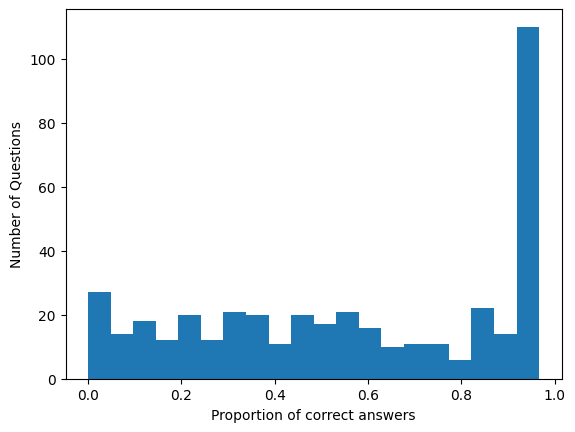

In [141]:
plt.hist(item_summary['prop_correct'],bins=20)
plt.xlabel("Proportion of correct answers")
plt.ylabel("Number of Questions")
plt.show()



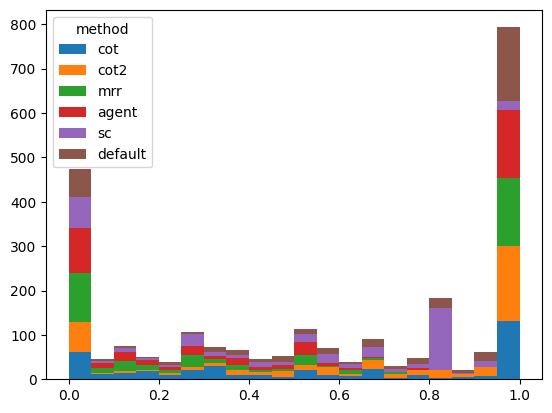

In [114]:
df = [
    g['prop_correct'].values
    for _, g in item_summary.groupby('method')
]

labels = item_summary['method'].unique()

plt.hist(
    df,
    bins=20,
    stacked=True,
    label=labels
)

plt.legend(title='method')
plt.show()








